### Refit Without removing indeterminate
---

We may achieve better results by not removing indeterminate...Let's take a look

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load modeling_df
dev_path = "s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-02/modeling_df_2021-02.parquet"
modeling_df = pd.read_parquet(dev_path)
modeling_df = mu.preprocess(modeling_df)

In [3]:
modeling_df.sample_date.min(), modeling_df.sample_date.max()

(Timestamp('2019-02-01 00:00:00'), Timestamp('2020-10-31 00:00:00'))

In [4]:
# where to save artifacts
govn_path = "../../artifacts/monitoring-2021Q1/refitted-w-indet"
os.makedirs(govn_path, exist_ok=True)

# load configs
with open("../../config.json", "r") as f:
    config = json.load(f)

In [5]:
test_dfs = OrderedDict()

In [6]:
mmonth = "2021-02"
s3_data_base = f"s3://sofi-data-science/jxu/monitoring/customer-risk-v1/{mmonth}"

model_name = f"customer_risk_{mmonth}_w_indet.pkl"
refit_model_s3_key = f"jxu/money-risk-models/customer-risk-model/models/{model_name}"

# refitting data
train_fname = f"modeling_df_{mmonth}.parquet"
modeling_data_path = os.path.join(s3_data_base, train_fname)
modeling_base_path = "../../models"

# test data
scoring_data_base = f"s3://sofi-data-science/jxu/monitoring/customer-risk-v1/{mmonth}"
scoring_data_files = [{"fpath": f"test_df_{mmonth}.parquet", 
                       "fname": f"test_df_{mmonth}"}]


#### Get and Process Data

In [7]:
test_df = refit.get_test_df(scoring_data_base, 
                            scoring_data_files)

test_df_2021-02 preprocessed


<AxesSubplot:>

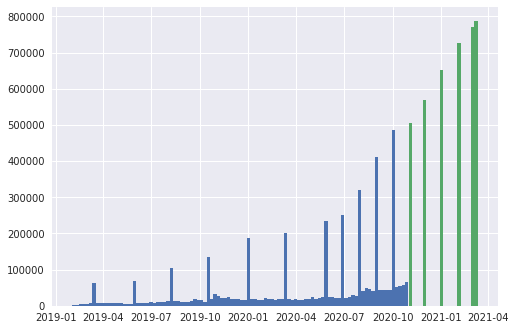

In [8]:
modeling_df.sample_date.hist(bins=100)
test_df.sample_date.hist(bins=20)

#### Refit

In [9]:
clf = refit.train(modeling_df,
                  date_col="sample_date",
                  indeterminate_col=None)

modeling_df last date: 2020-10-31 00:00:00
target counts
False    4060235
True      143180
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Cur

In [10]:
mu.write_pickle_to_s3(clf, "sofi-data-science", refit_model_s3_key) 
print(refit_model_s3_key)

jxu/money-risk-models/customer-risk-model/models/customer_risk_2021-02_w_indet.pkl


#### Gvrn Stuff

saving feature importance


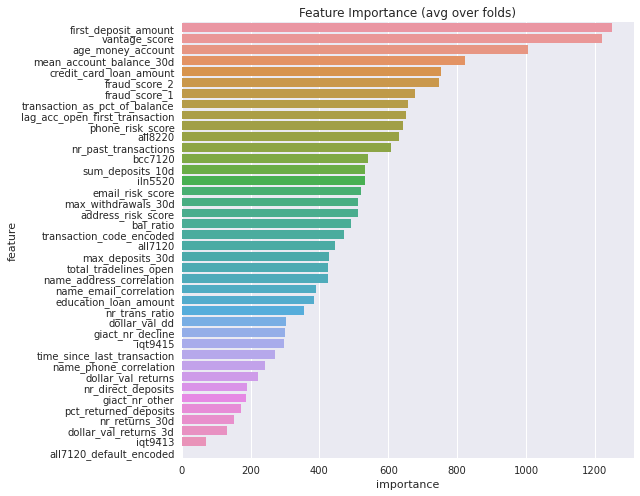

In [11]:
# save feature importance
print("saving feature importance")
gvrn.save_feature_importance_plot(clf.feature_name_, clf.feature_importances_, 
                             os.path.join(govn_path, "feature_importance.png"))

In [12]:
test_dts = test_df.sample_date.unique()
test_dts

array(['2020-11-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000',
       '2021-01-01T00:00:00.000000000', '2021-02-01T00:00:00.000000000',
       '2021-03-01T00:00:00.000000000', '2021-03-12T00:00:00.000000000'],
      dtype='datetime64[ns]')

  0%|          | 0/6 [00:00<?, ?it/s]

2020-11-01 (504084, 97)
data imbalance:  108.26546391752576


 17%|█▋        | 1/6 [00:08<00:40,  8.16s/it]

2020-12-01 (568715, 97)
data imbalance:  96.5560271646859


 33%|███▎      | 2/6 [00:15<00:30,  7.73s/it]

2021-01-01 (651893, 97)
data imbalance:  146.36124831612034


 50%|█████     | 3/6 [00:23<00:23,  7.94s/it]

2021-02-01 (725245, 97)
data imbalance:  206.56365707775564


 67%|██████▋   | 4/6 [00:32<00:16,  8.30s/it]

2021-03-01 (770065, 97)
data imbalance:  335.9794938917976


 83%|████████▎ | 5/6 [00:42<00:08,  8.70s/it]

2021-03-12 (786936, 97)
data imbalance:  440.6136618141097


100%|██████████| 6/6 [00:51<00:00,  8.56s/it]


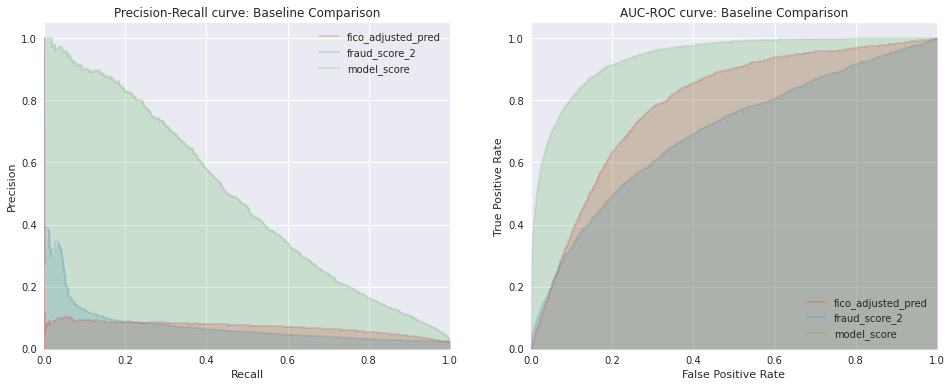

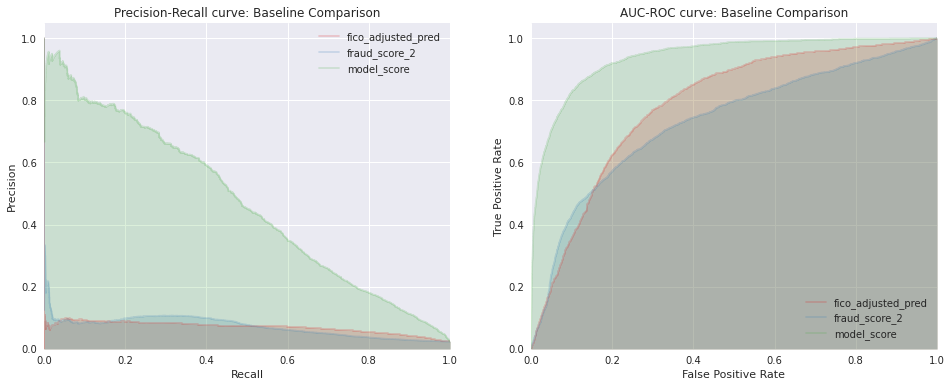

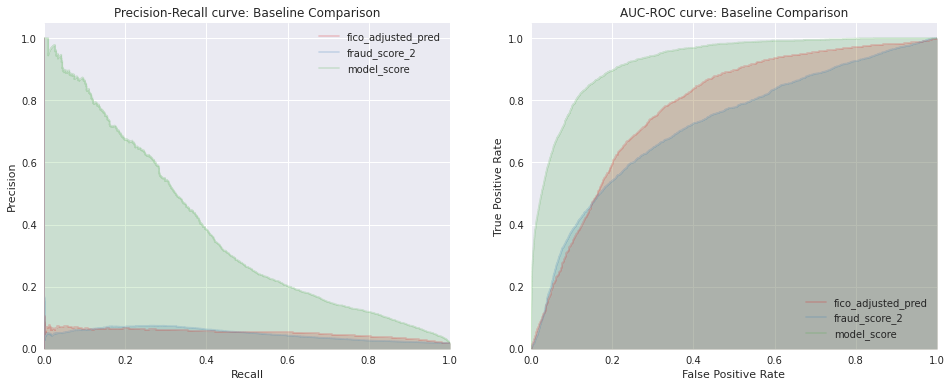

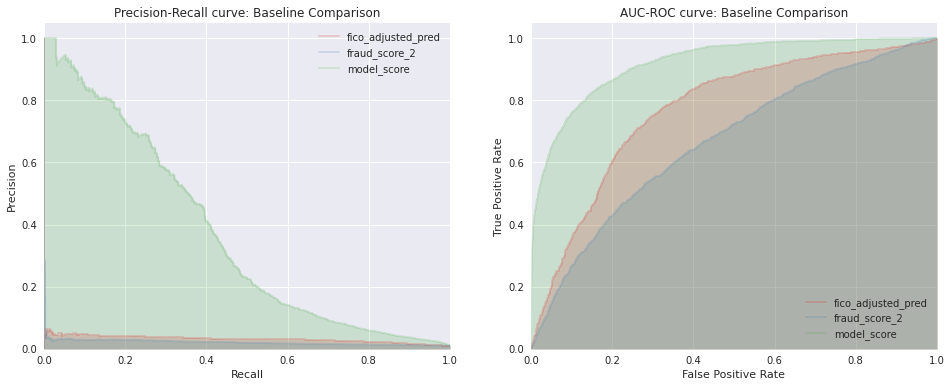

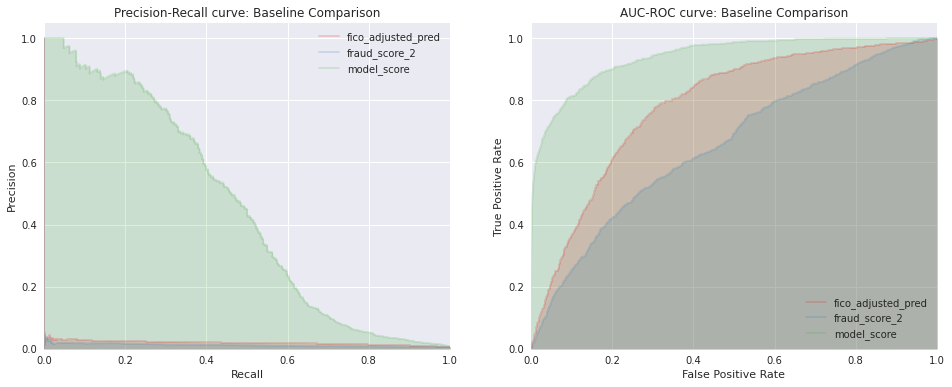

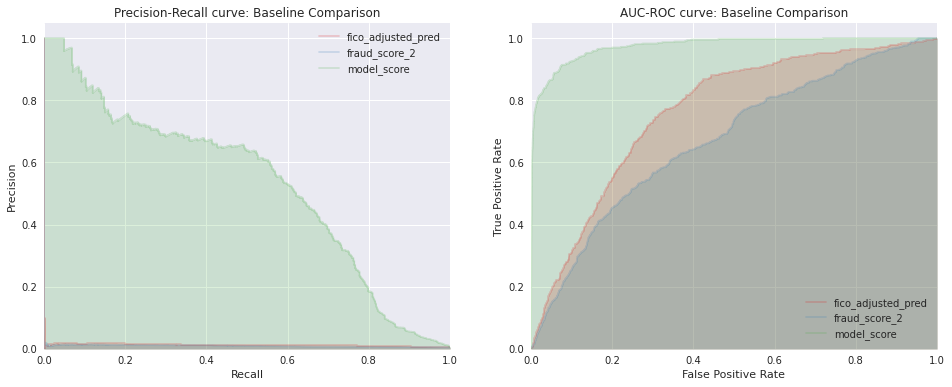

In [13]:
# get all the snapshots
for dt in tqdm(test_dts):
    dt_str = str(dt).split("T")[0]

    # set folder:
    mntr_path = os.path.join(govn_path, dt_str)
    os.makedirs(mntr_path, exist_ok=True)

    # get data on that date
    df_ = test_df[test_df.sample_date == dt]
    print(dt_str, df_.shape)

    # see data imbalance
    print("data imbalance: ", 1/df_.target.value_counts(normalize=True).iloc[1])

    # should have been processed when loaded, if not uncomment
    df_ = mu.prep_customer_data(df_)

    # make model pred and score
    df_["model_pred"] = clf.predict_proba(df_[clf.feature_name_])[:,1]
    df_["model_score"] = mu.scale_scores(df_["model_pred"])

    # insert into records
    test_dfs[dt_str] = df_
    pred_cols = ["fico_adjusted_pred", "fraud_score_2", "model_score"]
    report = mntr.get_pred_reports(df_[df_.is_active], "target", pred_cols, dropna=True)

    # store report in monitoring
    report.to_csv(os.path.join(mntr_path, f"{dt_str}_perf.csv"))

    # model prediction
    mntr.get_segmented_performances(
        {dt_str: df_[df_.is_active]},
        "target",
        ["model_score"],
        mntr_path,
        model_name="customer_risk",
    )

    # auc/pr plots
    plot_df = df_[df_.is_active].copy()
    plot_df = plot_df[
        ~plot_df[pred_cols].isna().any(axis=1) 
        & plot_df["fico_score"].between(300, 850)
    ]
    mntr.save_valid_performance_plots(
        {dt_str: plot_df}, "target", pred_cols, mntr_path, dropna=False
    )

  0%|          | 0/6 [00:00<?, ?it/s]

2020-11-01 (504084, 97)
data imbalance:  108.26546391752576


 17%|█▋        | 1/6 [00:23<01:58, 23.75s/it]

2020-12-01 (568715, 97)
data imbalance:  96.5560271646859


 33%|███▎      | 2/6 [00:50<01:42, 25.61s/it]

2021-01-01 (651893, 97)
data imbalance:  146.36124831612034


 50%|█████     | 3/6 [01:21<01:24, 28.17s/it]

2021-02-01 (725245, 97)
data imbalance:  206.56365707775564


 67%|██████▋   | 4/6 [01:56<01:01, 30.75s/it]

2021-03-01 (770065, 97)
data imbalance:  335.9794938917976


 83%|████████▎ | 5/6 [02:33<00:33, 33.05s/it]

2021-03-12 (786936, 97)
data imbalance:  440.6136618141097


100%|██████████| 6/6 [03:11<00:00, 31.90s/it]


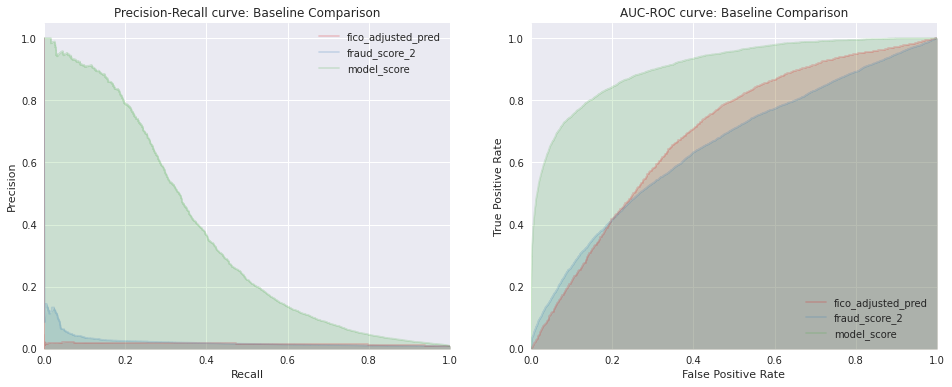

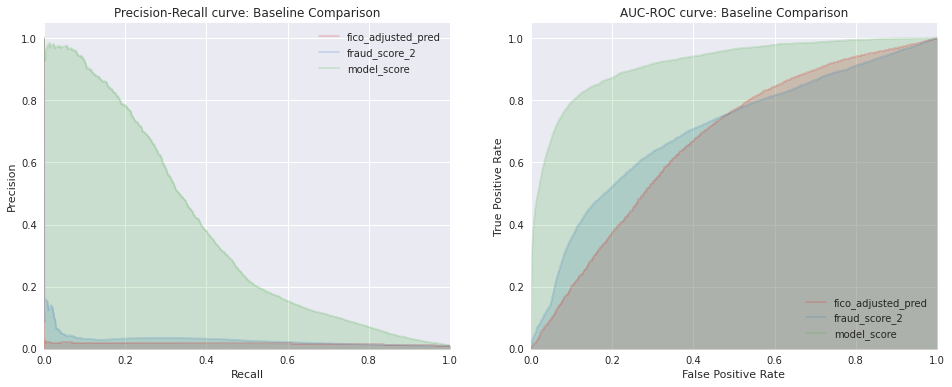

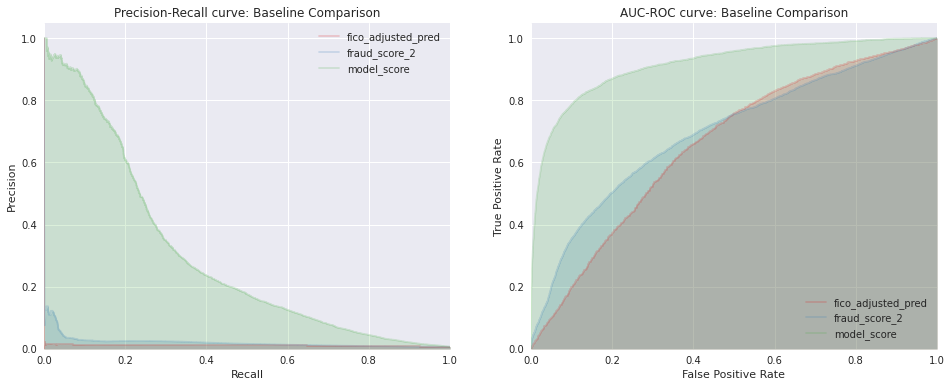

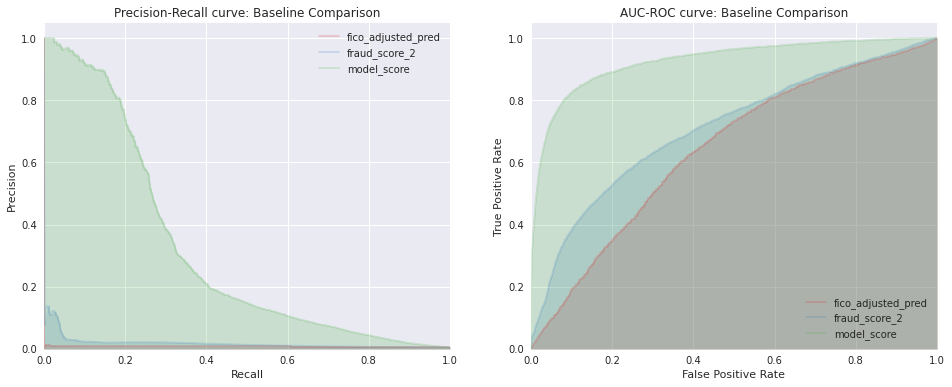

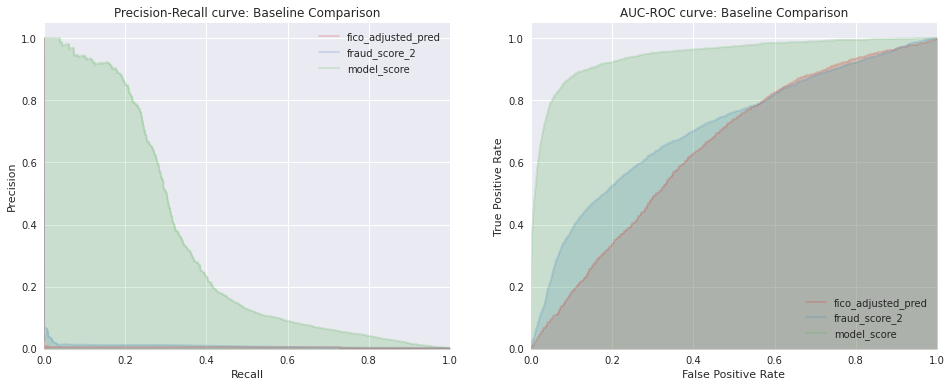

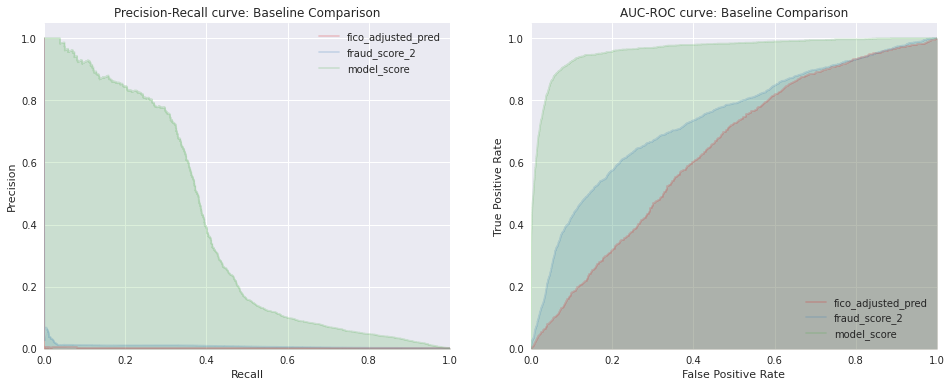

In [14]:
# get full population
for dt in tqdm(test_dts):
    dt_str = str(dt).split("T")[0]

    # set folder:
    mntr_path = os.path.join(govn_path, dt_str+"_all")
    os.makedirs(mntr_path, exist_ok=True)

    # get data on that date
    df_ = test_df[test_df.sample_date == dt]
    print(dt_str, df_.shape)

    # see data imbalance
    print("data imbalance: ", 1/df_.target.value_counts(normalize=True).iloc[1])

    # should have been processed when loaded, if not uncomment
    df_ = mu.prep_customer_data(df_)

    # make model pred and score
    df_["model_pred"] = clf.predict_proba(df_[clf.feature_name_])[:,1]
    df_["model_score"] = mu.scale_scores(df_["model_pred"])

    # insert into records
    test_dfs[dt_str] = df_
    pred_cols = ["fico_adjusted_pred", "fraud_score_2", "model_score"]
    report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)

    # store report in monitoring
    report.to_csv(os.path.join(mntr_path, f"{dt_str}_perf.csv"))

    # model prediction
    mntr.get_segmented_performances(
        {dt_str: df_},
        "target",
        ["model_score"],
        mntr_path,
        model_name="customer_risk",
    )

    # auc/pr plots
    plot_df = df_.copy()
    plot_df = plot_df[
        ~plot_df[pred_cols].isna().any(axis=1) 
        & plot_df["fico_score"].between(300, 850)
    ]
    mntr.save_valid_performance_plots(
        {dt_str: plot_df}, "target", pred_cols, mntr_path, dropna=False
    )

### Refitted Score distribution vs. Last iteration

In [17]:
df_.sample_date.unique()

array(['2021-03-12T00:00:00.000000000'], dtype='datetime64[ns]')

2021-03-12T00:00:00.000000000


<AxesSubplot:>

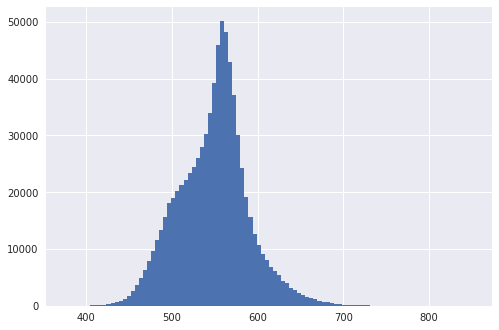

In [18]:
print(dt)
cur_df = df_
cur_df.model_score.hist(bins=100)

In [29]:
# old model new data
prev_model_s3_key = "jxu/money-risk-models/customer-risk-model/models/customer_risk_target_no_giact_time_since_last_link.pkl"
prev_model = mu.read_pickle_from_s3("sofi-data-science", prev_model_s3_key)
cur_df["prev_model_pred"] = prev_model.predict_proba(cur_df[model.feature_name_])[:, 1]
cur_df["prev_model_score"] = mu.scale_scores(cur_df["prev_model_pred"])

In [19]:
# artifacts path
artifact_path = "../../artifacts/monitoring-2021Q1/psi" 
os.makedirs(artifact_path, exist_ok=True)

# load configs
with open("../../config.json", "r") as f:
    config = json.load(f)

# dev data get and process
dev_path = "s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-02/dev-data.parquet"
df = pd.read_parquet(dev_path)
df = mu.prep_customer_data(df)
    
# find the first day to start monitoring
dev_snapshot_date = pd.to_datetime("2020-01-01")
prod_snapshot_date = "2021-02-19"
df_dev = df[df.sample_date == dev_snapshot_date]
display(df_dev.sample_date.value_counts(), df_dev.shape)

# prod data
df_prod = pd.read_parquet(f's3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-02/prod-data-{prod_snapshot_date}.parquet')

# load model from s3
prev_model_s3_key = "jxu/money-risk-models/customer-risk-model/models/customer_risk_target_no_giact_time_since_last_link.pkl"
model = mu.read_pickle_from_s3("sofi-data-science", prev_model_s3_key)

2020-01-01    166193
Name: sample_date, dtype: int64

(166193, 98)

In [20]:
df_dev["model_pred"] = model.predict_proba(df_dev[model.feature_name_])[:,1]
df_dev["model_score"] = mu.scale_scores(df_dev["model_pred"])

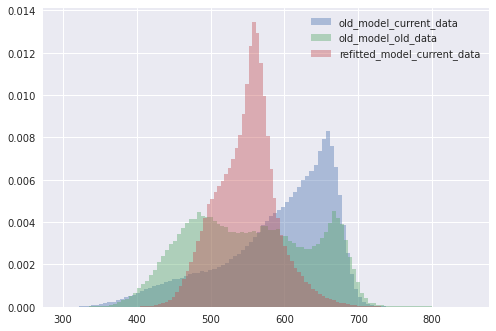

In [30]:
cur_df.prev_model_score.hist(bins=100, alpha=0.4, density=True, label="old_model_current_data")
df_dev.model_score.hist(bins=100, alpha=0.4, density=True, label="old_model_old_data") # immediately after training
cur_df.model_score.hist(bins=100, alpha=0.4, density=True, label="refitted_model_current_data")
plt.legend()

In [26]:
df_dev.sample_date.unique(), df_prod.last_checked_date.max()

(array(['2020-01-01T00:00:00.000000000'], dtype='datetime64[ns]'),
 '2021-02-18 23:59:41.476')